LAST UPDATED ON 2023/05/02

1. aims at fast testing of the trained model

# Import Libraries

In [5]:
import os
import cv2
import copy
import random
import numpy as np

from marco import *
from network import *
from utilities import *
from visualise import *

# Define Parameters

In [6]:
#define class name to class index
CLS2IND = {'cat': 0, 
           'dog': 1}
#define class index to class name
IND2CLS = {0: 'cat', 
           1: 'dog'}

#define figure for visualization
N_COL = 4
N_ROW = 4

#number of grid in one row or column
GRID_NUM  = 7
#threshold of objectness confidence
OBJ_CONF_THRESHOLD = 0.2
#thresould of IOU
IOU_THRESHOLD = 0.3

#obtain the images in the "example_img" folder
img_path = os.listdir('example_img')
img_path = sorted([os.path.join('example_img', f) for f in img_path if f.split('.')[-1] == 'jpg'])


# Initialize Detection Network

In [7]:
net = Det_Network()
net_model = net.obj_det()
net_model.load_weights('det_model/best_det_model.h5')

1/1 [==============================] - 0s 253ms/step


2023-05-02 19:28:48.165771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


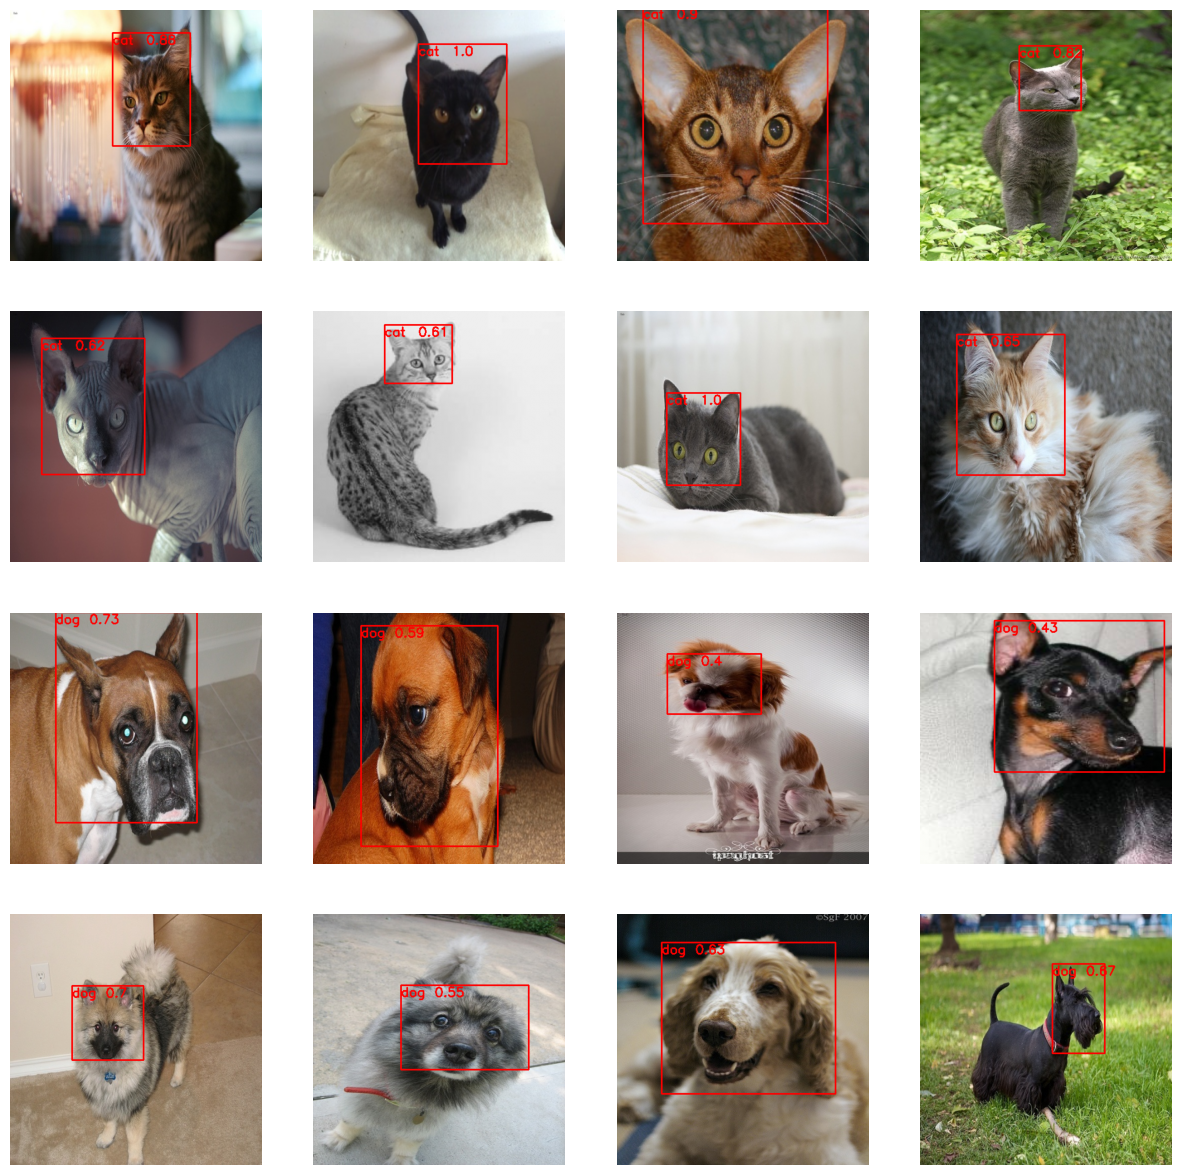

In [8]:
row_ind = col_ind = 0
fig, ax = plt.subplots(nrows = N_ROW, ncols = N_COL, figsize = (15, 15))
plt.axis('off')

for img_load in img_path:
    img = cv2.cvtColor(cv2.imread(img_load), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (448, 448), interpolation=cv2.INTER_AREA)
    img = img/255.
    img_h, img_w, _ = img.shape

    draw_img = copy.deepcopy(img)
        
    #======= prediction =======#
    p = net_model.predict(np.expand_dims(img, 0))
    cvt_pred_mat = cvt_cell_ratio_to_img_ratio(p)

    #======= extract prediction data =======#
    box_p = []
    obj_p = []

    for i in range(GRID_NUM):
        for j in range(GRID_NUM):
            if cvt_pred_mat[0, i, j, 1] > OBJ_CONF_THRESHOLD:
                cls_ind = cvt_pred_mat[0, i, j, 0].numpy()
                tmp = [0] + list(cvt_pred_mat[0, i, j, :].numpy())
                box_p.append(tmp)
                obj_p.append(IND2CLS[cls_ind])
    box_p = np.array(box_p)

    #======= compute nms =======#
    if len(box_p) > 0:
        nms_box = compute_nms(box_p.copy(), 
                              iou_t = IOU_THRESHOLD, 
                              conf_t = OBJ_CONF_THRESHOLD)
        
        if nms_box.size > 0: 
            if len(nms_box.shape) == 1:
                nms_box = np.expand_dims(nms_box, 0)
            
            nms_obj = []
            for i in range(len(nms_box)):
                nms_obj.append(IND2CLS[nms_box[i, 1]])
            
            #======= draw predicted bounding boxes on images =======#
            y_box = yolo2minmax(nms_box[:,3:], img_w, img_h)
            for i in range(len(y_box)):
                #the conf. scores could be larger than 1. or smaller than 0.
                nms_box[i, 2] = max(min(1, nms_box[i, 2]), 0)
                #add confidence scores to the yolo format boxes
                y_box[i] = y_box[i] + [nms_box[i, 2]]
                
            draw_img = visualise_boxes(draw_img, 
                                    y_box,
                                    objs = nms_obj,
                                    fontscale = 0.75,
                                    thickness = 2,
                                    is_show_scores = True,
                                    color = [255, 0, 0],
                                    )
        
    ax[row_ind, col_ind].imshow(draw_img)
    ax[row_ind, col_ind].axis('off')
    
    col_ind += 1
    if col_ind >= N_COL:
        col_ind = 0
        row_ind += 1